In [1]:
# Import modules
import os
import glob
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from fiona.crs import from_epsg
from shapely.geometry import box
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib.colors import LinearSegmentedColormap

import gdal

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


def reproject_to_template(input_raster, template_raster, output_raster, resolution=None,
                          resampling=gdal.GRA_Bilinear, nodata_val=0):
    """
    Reprojects a raster to match the extent, cell size, projection and dimensions of a template
    raster using GDAL. Optionally, can set custom resolution for output reprojected raster using
    'resolution'; this will affect raster dimensions/width/columns.

    Last modified: April 2018
    Author: Robbi Bishop-Taylor

    :param input_raster:
        Path to input geotiff raster to be reprojected (.tif)

    :param template_raster:
        Path to template geotiff raster (.tif) used to copy extent, projection etc

    :param output_raster:
        Output reprojected raster path with geotiff extension (.tif)

    :param resolution:
        Optionally set custom cell size for output reprojected raster; defaults to
        'None', or the cell size of template raster

    :param resampling:
        GDAL resampling method to use for reprojection; defaults to gdal.GRA_Bilinear

    :param nodata_val:
        Values in the output reprojected raster to set to nodata; defaults to 0

    :return:
        GDAL dataset for further analysis, and raster written to output_raster (if this
        dataset appears empty when loaded into a GIS, close the dataset like 'output_ds = None')

    """

    # Import raster to reproject
    print("Importing raster datasets")
    input_ds = gdal.Open(input_raster)
    input_proj = input_ds.GetProjection()
    input_geotrans = input_ds.GetGeoTransform()
    data_type = input_ds.GetRasterBand(1).DataType
    n_bands = input_ds.RasterCount

    # Import raster to use as template
    template_ds = gdal.Open(template_raster)
    template_proj = template_ds.GetProjection()
    template_geotrans = template_ds.GetGeoTransform()
    template_w = template_ds.RasterXSize
    template_h = template_ds.RasterYSize

    # Use custom resolution if supplied
    if resolution:
        template_geotrans[1] = float(resolution)
        template_geotrans[-1] = -float(resolution)

    # Create new output dataset to reproject into
    output_ds = gdal.GetDriverByName('Gtiff').Create(output_raster, template_w,
                                                     template_h, n_bands, data_type)
    output_ds.SetGeoTransform(template_geotrans)
    output_ds.SetProjection(template_proj)
    output_ds.GetRasterBand(1).SetNoDataValue(nodata_val)

    # Reproject raster into output dataset
    print("Reprojecting raster")
    gdal.ReprojectImage(input_ds, output_ds, input_proj, template_proj, resampling)

    # Close datasets
    input_ds = None
    template_ds = None

    print("Reprojected raster exported to {}".format(output_raster))
    return output_ds


# Working directory
os.chdir('/g/data/r78/rt1527/nidem')

In [33]:
# Input datasets
polygon_ID = 66

# Dict of file paths
path_dict = {'nidem_dem': 'output_data/geotiff/dem/NIDEM_dem_{}.tif'.format(polygon_ID), 
             'nidem_unfiltered': 'output_data/geotiff/dem_unfiltered/NIDEM_unfiltered_{}.tif'.format(polygon_ID),
             'nidem_mask': 'output_data/geotiff/mask/NIDEM_mask_{}.tif'.format(polygon_ID),
             'nidem_raw': 'output_data/geotiff/NIDEM_raw_{}.tif'.format(polygon_ID),
             'item_relative': glob.glob('/g/data2/v10/ITEM/rel_products/ITEM_REL_{}_*.tif'.format(polygon_ID))[0],
             'item_confidence': glob.glob('/g/data2/v10/ITEM/conf_products/ITEM_STD_{}_*.tif'.format(polygon_ID))[0]}

# Centre point
lat, lon = -20.9700620057, 149.085064352

In [34]:
# # Reproject SRTM-derived 1 Second DEM to cell size and projection of NIDEM
# reproject_to_template(input_raster='/g/data/rr1/Elevation/1secSRTM_DEMs_v1.0/DEM/Mosaic/dem1sv1_0',
#                       template_raster=path_dict['nidem_dem'],
#                       output_raster='scratch/srtm_raster.tif',
#                       nodata_val=-9999)

# # Reproject GBR30 bathymetry to cell size and projection of NIDEM
# reproject_to_template(input_raster='/g/data/r78/rt1527/datasets/GBR30/02_ESRI_Raster/gbr30_ALL/gbr30_all',
#                       template_raster=path_dict['nidem_dem'],
#                       output_raster='scratch/gbr30_raster.tif',
#                       nodata_val=-9999)

path_dict['srtm'] = 'scratch/srtm_raster.tif'
path_dict['gbr30'] = 'scratch/gbr30_raster.tif'

In [35]:
# Compute buffer 
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
x_topleft, x_bottomright = (x - 8500, x + 8500)
y_topleft, y_bottomright = (y - 7000, y + 7000)

# Create bounding box
bbox = box(x_topleft, y_bottomright, x_bottomright, y_topleft)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(3577))
coords = getFeatures(geo)

In [36]:
array_dict = {}

for dataset, path in path_dict.items():
    
    # Import data and clip
    data = rasterio.open(path)
    out_img, out_transform = mask(raster=data, shapes=coords, crop=True)

    # Fix any nodata in dataset
    out_img = out_img.astype(np.float)
    out_img[out_img == -6666] = np.nan
    out_img[out_img == -9999] = np.nan

    # Copy the metadata
    out_meta = data.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform})

    # Assign array to dict
    array_dict[dataset] = out_img[0, :, :]

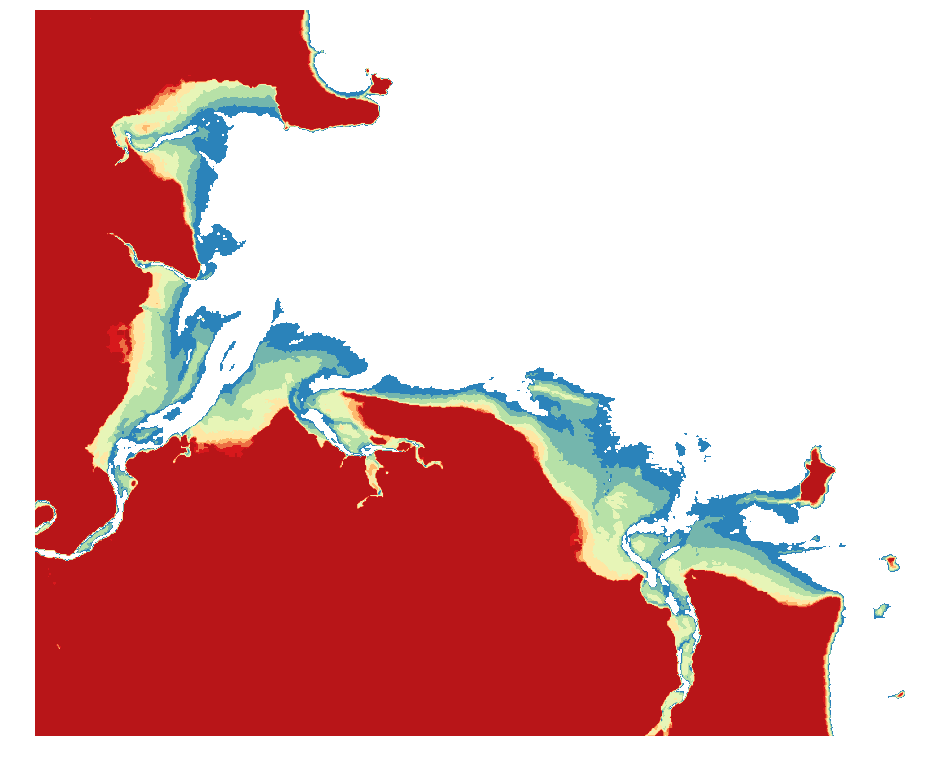

In [72]:
# # Plot SRTM
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['srtm'], cmap='Greys_r', vmin= -10, vmax = 50)
# fig.savefig("figures/{}.png".format('srtm'), pad_inches = 0)

# # Plot GBR30
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['gbr30'], cmap='Greys_r', vmin= -15, vmax = 10)
# fig.savefig("figures/{}.png".format('gbr30'), pad_inches = 0)

# # Plot NIDEM 
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['nidem_dem'], cmap='viridis')
# fig.savefig("figures/{}.png".format('nidem_dem'), pad_inches = 0)

# # Plot NIDEM unfiltered
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['nidem_unfiltered'], cmap='viridis')
# fig.savefig("figures/{}.png".format('nidem_unfiltered'), pad_inches = 0)

# # Plot NIDEM  raw
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['nidem_raw'], cmap='viridis')
# fig.savefig("figures/{}.png".format('nidem_raw'), pad_inches = 0)

# # Plot NIDEM mask
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# item_cs = ['dimgrey', 'dimgrey', 'dimgrey']
# item_cm = LinearSegmentedColormap.from_list('item', item_cs, N=3)
# plt.imshow(array_dict['nidem_mask'], cmap=item_cm, interpolation='bilinear')
# fig.savefig("figures/{}.png".format('nidem_mask'), pad_inches = 0)

# Plot ITEM relative
fig, ax = plt.subplots() 
fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
fig.set_size_inches(12,10)
ax.axis('off')
item_cs = ['white', '#2b83ba', '#74b6ad', '#b7e1a7', '#e7f5b7', 
           '#fee7a4', '#fdb96e', '#ec6e43', '#d7191c', '#b81518']  # '#1a6a9d'
item_cm = LinearSegmentedColormap.from_list('item', item_cs, N=10)
plt.imshow(array_dict['item_relative'], cmap=item_cm, interpolation='bilinear')
fig.savefig("figures/{}.png".format('item_relative'), pad_inches = 0)

# # Plot ITEM confidence
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['item_confidence'], cmap='RdYlBu_r', interpolation='bilinear')
# fig.savefig("figures/{}.png".format('item_confidence'), pad_inches = 0)

In [47]:
# Create bounding box
bbox = box(x_topleft, y_bottomright, x_bottomright, y_topleft)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(3577))
coords = getFeatures(geo)

In [48]:
geo

I am densified (1 elements)
I am densified (1 elements)


,geometry
0,POLYGON ((1768517.547712673 -2362952.414500819...


In [58]:
new = gpd.GeoDataFrame.from_file('/g/data/r78/rt1527/nidem/output_data/contour/NIDEM_contours_66.shp')
new


I am densified (9 elements)
I am densified (9 elements)


,elevation,geometry
0,-1.51,"(LINESTRING (1759287.5 -2296076.463332774, 175..."
1,-1.08,"(LINESTRING (1759182.303494624 -2295962.5, 175..."
2,-0.64,"(LINESTRING (1759168.159946237 -2295962.5, 175..."
3,-0.20,"(LINESTRING (1759162.5 -2295935.100440998, 175..."
4,0.24,"(LINESTRING (1759162.5 -2295931.099984793, 175..."
5,0.68,"(LINESTRING (1759162.5 -2295927.099528589, 175..."
6,1.12,"(LINESTRING (1759162.5 -2295923.099072385, 175..."
7,1.55,"(LINESTRING (1759162.5 -2295919.09861618, 1759..."
8,1.99,"(LINESTRING (1759162.5 -2295915.098159976, 175..."


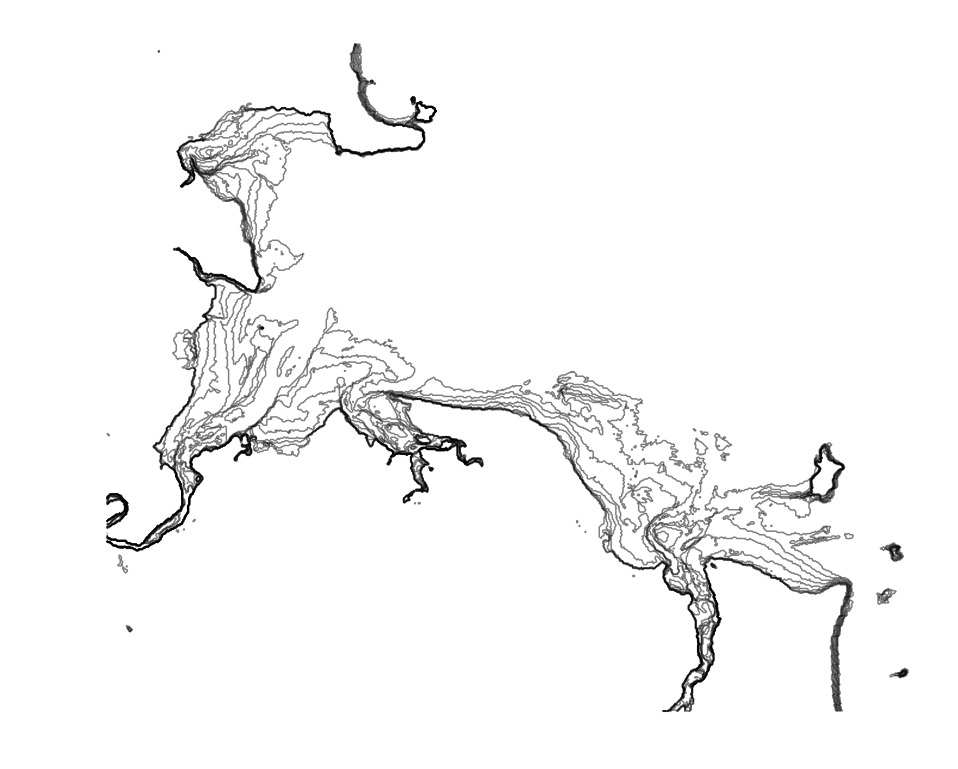

In [70]:
fig, ax = plt.subplots() 
fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
fig.set_size_inches(12,10)
ax.axis('off')
new.intersection(geo.unary_union).plot(ax = ax, alpha=0.5, edgecolor='black')
fig.savefig("figures/{}.png".format('contours'), pad_inches = 0)